
# Using Python and pySpark
### Fluorescence, PRI and Carbon GPP relationships in Barbeau Forest 
 

### 1. Check is PySpark is available 

In [63]:
try:
    from pyspark import SparkContext
    print("PySpark is available in this machine")
except ImportError:
    print("PySpark is not installed in this machine, use pip manager to install Apache PySpark API Python")

PySpark is available in this machine


### 2. Open a PySpark session and give a name to the section

In [64]:
%reset -f
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.appName("SIG_PRI_GPP").getOrCreate()
import pandas as pd
import matplotlib.pyplot as plt

## 3. Open the CSV file and print colnames usin Spark

In [ ]:
path_name= "D:/SynergySIF_PRI_GPP/SpectralData/"
file_name= "meta_HR_24_11_2023_GH.csv"
file=path_name+file_name
print(file)
# Read a CSV file into a DataFrame
df_SpecData = spark.read.csv(file, inferSchema=True, header=True, sep=';')
#print(df_SpecData.columns)
# Print column names, each on a new line
for column in df_SpecData.columns:
    print("Column name: " + column)

#### 3.1.  data Types

In [ ]:
df_SpecData.printSchema()

#### 3.2. Show data (equivalent to head() in Pandas)

In [ ]:
df_SpecData.show()

#### 3.3. Dealing with timeStamp in Spark
The two columns Time_Start and Time_End are Timestamp in format dd/MM/yyyy HH:MM. In Spark the two columns have string type. How to convert them to data and time in spark

In [68]:
from pyspark.sql.functions import to_timestamp

# Convert 'Time_Start' and 'Time_End' to datetime
df_SpectData = df_SpecData.withColumn("Time_start", to_timestamp("Time_start", 'dd/MM/yyyy HH:mm'))
df_SpectData = df_SpectData.withColumn("Time_end", to_timestamp("Time_end", 'dd/MM/yyyy HH:mm'))

In [ ]:
df_SpectData.printSchema()

#### 3.4. Plot time series - Note that pyspark dataframe needs to be converted to pandas dataframe




##### 3.4.1. Convert Spark DataFrame to Pandas DataFrame


In [ ]:
p_df_SpectData = df_SpectData.toPandas()

##### 3.4.2. Plot time series 

In [71]:
# Assuming `pandas_df_SpectData` is your DataFrame and 'date' is your date column
p_df_SpectData['Time_start'] = pd.to_datetime(p_df_SpectData['Time_start'])
p_df_SpectData.set_index('Time_start', inplace=True)
p_df_filtered =p_df_SpectData[(p_df_SpectData['SIF_SFM_Co_tot']>= 0) & (p_df_SpectData['SIF_SFM_Co_tot']<= 0.3)]
p_df_filtered =p_df_filtered[(p_df_filtered['PRI']>= -0.2) & (p_df_filtered['PRI']<= 1)]
p_df_filtered =p_df_filtered[(p_df_filtered['NDVI']>= 0) & (p_df_filtered['NDVI']<= 1)]
p_df_filtered =p_df_filtered[(p_df_filtered['mNDI']>= 0.2) & (p_df_filtered['mNDI']<= 1)]


##### Filtering for sunny days

In [72]:
p_df_filtered=p_df_filtered[(p_df_filtered['PAR_micromoles_m_2s_1']>= 400)]


##### Filtering betwen two dates and two times

In [73]:

start_date = '2022-05-01'
end_date = '2022-09-30'
start_hour = 10
end_hour = 16

mask = (p_df_filtered.index.date >= pd.to_datetime(start_date).date()) & \
       (p_df_filtered.index.date <= pd.to_datetime(end_date).date()) & \
       (p_df_filtered.index.hour >= start_hour) & \
       (p_df_filtered.index.hour <= end_hour)

filtered_pd_Date = p_df_filtered.loc[mask]

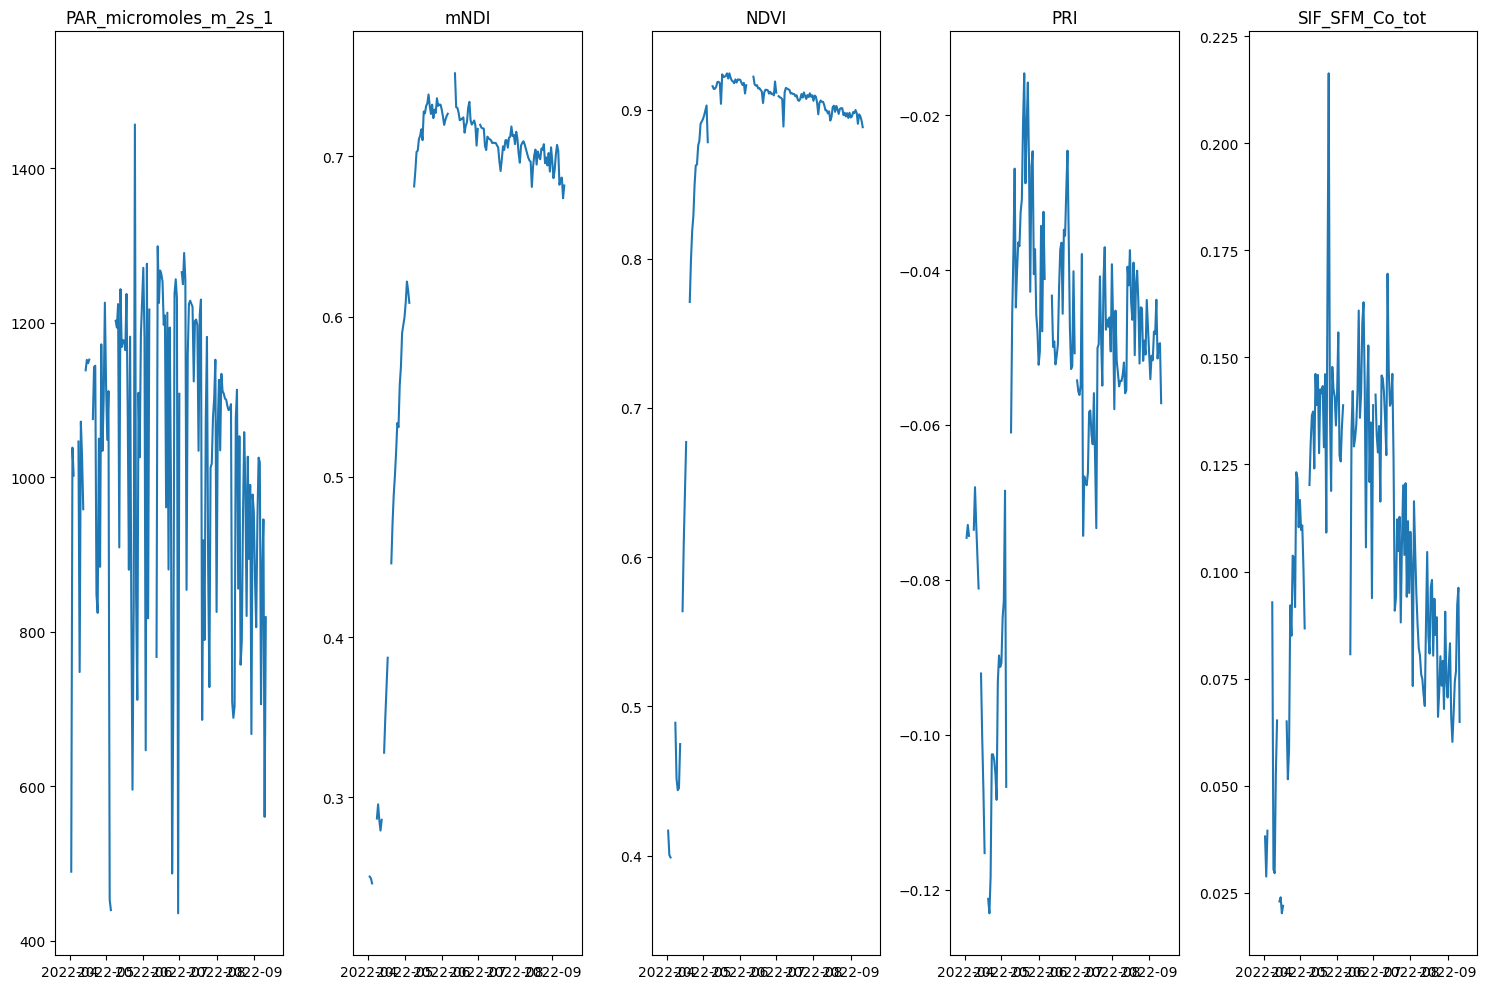

In [74]:
# Assuming `df` is your DataFrame
fig, axs = plt.subplots(1, 5, figsize=(15, 10))  # 1 row, 5 columns

variables = ['PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot']
df=p_df_filtered
for i, var in enumerate(variables):
    axs[i].plot(p_df_filtered[var].resample('D').mean())
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

##### Pairplot using seaborn

In [75]:
Subset_filteredData=filtered_pd_Date[['SIF_SFM_Co_tot','PRI','PAR_micromoles_m_2s_1','mNDI','NDVI']]

resampled_df_30mn = Subset_filteredData.resample('30T').mean()
resampled_df_30mn.head()

,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI
Time_start,,,,,
2022-05-01 10:00:00,0.116153,-0.086467,790.388010,0.592868,0.891552
2022-05-01 10:30:00,0.104939,-0.087394,574.492800,0.592928,0.893609
2022-05-01 11:00:00,0.100794,-0.082351,600.952029,0.602933,0.894330
2022-05-01 11:30:00,0.086282,-0.078302,623.376600,0.624390,0.900825
2022-05-01 12:00:00,NaN,NaN,NaN,NaN,NaN


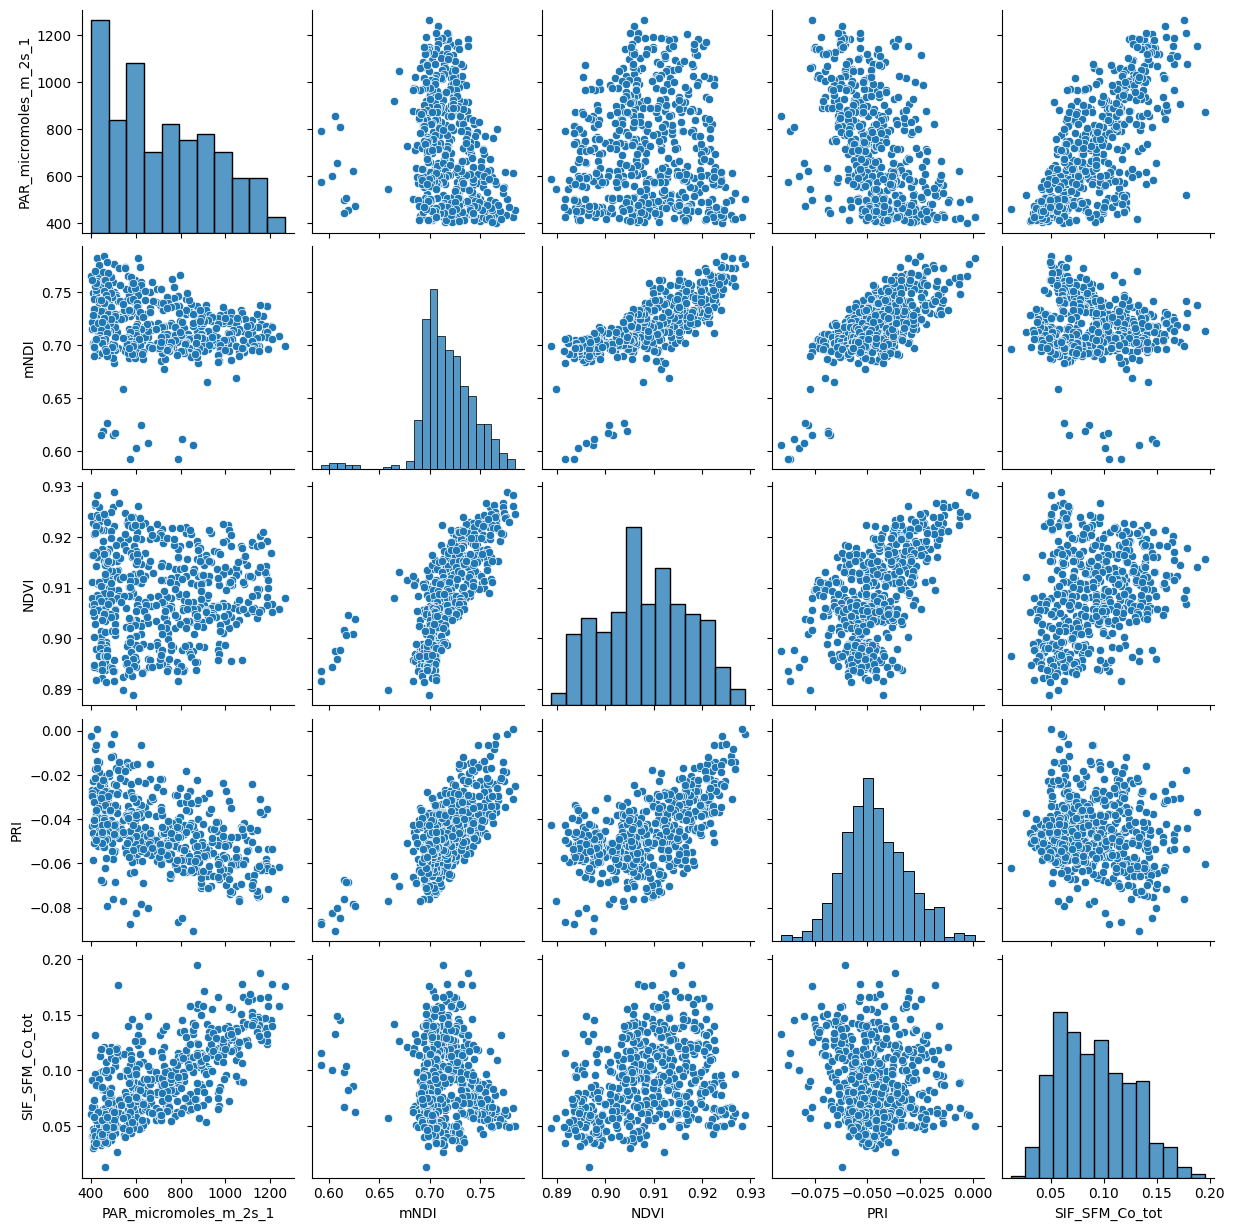

In [97]:
# Assuming `df` is your DataFrame and 'var1', 'var2', 'var3', 'var4' are your variables
import seaborn as sns
sns.pairplot(resampled_df_30mn[['PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot']])
plt.show()

## 4. Random Forest Regression Model using Spark MLlib

#### 4.1. Convert Pandas dataframe to PySpark dataframe

In [100]:

spark_df = spark.createDataFrame(resampled_df_30mn)
spark_df.printSchema()

root
 |-- SIF_SFM_Co_tot: double (nullable = true)
 |-- PRI: double (nullable = true)
 |-- PAR_micromoles_m_2s_1: double (nullable = true)
 |-- mNDI: double (nullable = true)
 |-- NDVI: double (nullable = true)

